# Root fit analyzing neural network


By Brady Lowe

lowebra2@isu.edu

7/25/2018


This Jupyter notebook was written to both develope and explain how we can use
neural networks to analyze the output of root fits to raw data.

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Load dataset
x, y = nn_utils.load_dataset(im_dir="train")
x_dev, y_dev = nn_utils.load_dataset(im_dir="dev")

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))


(m, height, width, channels): (3312, 236, 348, 3)
m_dev: 465


label: bad
label: [0]


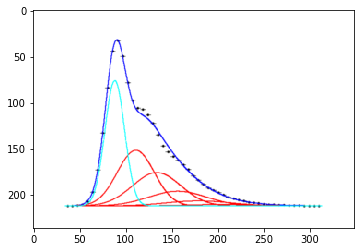

In [3]:
# Print an image
index = 777
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
plt.imshow(np.uint8(nn_utils.get_printable_image(this_image)))

## Define and Train 3 layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [4]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(7)
strides.append(4)
pools.append(2)
dropouts.append(0.4)

# Conv2
filters.append(128)
kernels.append(5)
strides.append(3)
pools.append(2)
dropouts.append(0.4)

# Conv3
filters.append(256)
kernels.append(3)
strides.append(1)
pools.append(1)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 20
fc2 = 20

##### Define keras layers (model)

In [5]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)
# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=X, outputs=a)

# Print summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 236, 348, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 58, 86, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 58, 86, 32)        128       
_________________________________________________________________
a0 (Activation)              (None, 58, 86, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 29, 43, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 43, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 9, 13, 128)        102528    
__________

##### Define optimizer, loss, and metrics. Compile model.

In [6]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)

##### Fit the model to the data (train)

Train on 3312 samples, validate on 465 samples
Epoch 1/500
3312/3312 [==============================] - 21s 6ms/step - loss: 0.2147 - acc: 0.6673 - val_loss: 0.1931 - val_acc: 0.7204
Epoch 2/500
3312/3312 [==============================] - 14s 4ms/step - loss: 0.1965 - acc: 0.7117 - val_loss: 0.1860 - val_acc: 0.7269
Epoch 3/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.1911 - acc: 0.7089 - val_loss: 0.1816 - val_acc: 0.7204
Epoch 4/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.1911 - acc: 0.7126 - val_loss: 0.1786 - val_acc: 0.7484
Epoch 5/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.1878 - acc: 0.7192 - val_loss: 0.1748 - val_acc: 0.7269
Epoch 6/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.1863 - acc: 0.7156 - val_loss: 0.1740 - val_acc: 0.7312
Epoch 7/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.1872 - acc: 0.7068 - val_loss: 0.1722 - val_acc: 0.7419
E

3312/3312 [==============================] - 13s 4ms/step - loss: 0.0750 - acc: 0.9031 - val_loss: 0.1186 - val_acc: 0.8473
Epoch 61/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0711 - acc: 0.9055 - val_loss: 0.0839 - val_acc: 0.8946
Epoch 62/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0724 - acc: 0.9067 - val_loss: 0.0728 - val_acc: 0.9140
Epoch 63/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0690 - acc: 0.9121 - val_loss: 0.0695 - val_acc: 0.9118
Epoch 64/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0652 - acc: 0.9209 - val_loss: 0.1056 - val_acc: 0.8602
Epoch 65/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0656 - acc: 0.9209 - val_loss: 0.0700 - val_acc: 0.9097
Epoch 66/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0669 - acc: 0.9124 - val_loss: 0.0658 - val_acc: 0.9140
Epoch 67/500
3312/3312 [==============================

Epoch 120/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0368 - acc: 0.9523 - val_loss: 0.0682 - val_acc: 0.9097
Epoch 121/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0372 - acc: 0.9559 - val_loss: 0.0820 - val_acc: 0.9054
Epoch 122/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0387 - acc: 0.9508 - val_loss: 0.0799 - val_acc: 0.9075
Epoch 123/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0321 - acc: 0.9592 - val_loss: 0.0756 - val_acc: 0.9097
Epoch 124/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0338 - acc: 0.9586 - val_loss: 0.0978 - val_acc: 0.8839
Epoch 125/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0361 - acc: 0.9535 - val_loss: 0.1006 - val_acc: 0.8839
Epoch 126/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0353 - acc: 0.9556 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 127/500
3312/3312 [=========

3312/3312 [==============================] - 13s 4ms/step - loss: 0.0239 - acc: 0.9731 - val_loss: 0.0842 - val_acc: 0.9032
Epoch 180/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0241 - acc: 0.9698 - val_loss: 0.0802 - val_acc: 0.9054
Epoch 181/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0216 - acc: 0.9743 - val_loss: 0.0638 - val_acc: 0.9247
Epoch 182/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0234 - acc: 0.9701 - val_loss: 0.0794 - val_acc: 0.9097
Epoch 183/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0252 - acc: 0.9701 - val_loss: 0.0700 - val_acc: 0.9161
Epoch 184/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0240 - acc: 0.9710 - val_loss: 0.0707 - val_acc: 0.9118
Epoch 185/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0194 - acc: 0.9771 - val_loss: 0.0795 - val_acc: 0.9032
Epoch 186/500
3312/3312 [=======================

3312/3312 [==============================] - 14s 4ms/step - loss: 0.0202 - acc: 0.9749 - val_loss: 0.0671 - val_acc: 0.9247
Epoch 239/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0180 - acc: 0.9792 - val_loss: 0.0731 - val_acc: 0.9161
Epoch 240/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0150 - acc: 0.9825 - val_loss: 0.0699 - val_acc: 0.9204
Epoch 241/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0186 - acc: 0.9768 - val_loss: 0.0741 - val_acc: 0.9140
Epoch 242/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0180 - acc: 0.9783 - val_loss: 0.0678 - val_acc: 0.9204
Epoch 243/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0181 - acc: 0.9789 - val_loss: 0.0678 - val_acc: 0.9269
Epoch 244/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0187 - acc: 0.9740 - val_loss: 0.0697 - val_acc: 0.9204
Epoch 245/500
3312/3312 [=======================

3312/3312 [==============================] - 14s 4ms/step - loss: 0.0156 - acc: 0.9819 - val_loss: 0.0608 - val_acc: 0.9290
Epoch 298/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0145 - acc: 0.9819 - val_loss: 0.0694 - val_acc: 0.9204
Epoch 299/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0125 - acc: 0.9840 - val_loss: 0.0754 - val_acc: 0.9183
Epoch 300/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0134 - acc: 0.9831 - val_loss: 0.0511 - val_acc: 0.9355
Epoch 301/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0154 - acc: 0.9807 - val_loss: 0.0630 - val_acc: 0.9247
Epoch 302/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0135 - acc: 0.9834 - val_loss: 0.0747 - val_acc: 0.9161
Epoch 303/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0132 - acc: 0.9831 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 304/500
3312/3312 [=======================

3312/3312 [==============================] - 13s 4ms/step - loss: 0.0116 - acc: 0.9864 - val_loss: 0.0754 - val_acc: 0.9161
Epoch 357/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0104 - acc: 0.9879 - val_loss: 0.0636 - val_acc: 0.9312
Epoch 358/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0111 - acc: 0.9867 - val_loss: 0.0829 - val_acc: 0.9075
Epoch 359/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0116 - acc: 0.9849 - val_loss: 0.0630 - val_acc: 0.9269
Epoch 360/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0121 - acc: 0.9858 - val_loss: 0.0761 - val_acc: 0.9118
Epoch 361/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0103 - acc: 0.9870 - val_loss: 0.0671 - val_acc: 0.9247
Epoch 362/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0101 - acc: 0.9882 - val_loss: 0.0695 - val_acc: 0.9204
Epoch 363/500
3312/3312 [=======================

3312/3312 [==============================] - 13s 4ms/step - loss: 0.0089 - acc: 0.9888 - val_loss: 0.0636 - val_acc: 0.9333
Epoch 416/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0084 - acc: 0.9903 - val_loss: 0.0620 - val_acc: 0.9355
Epoch 417/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0081 - acc: 0.9903 - val_loss: 0.0665 - val_acc: 0.9269
Epoch 418/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0090 - acc: 0.9885 - val_loss: 0.0725 - val_acc: 0.9140
Epoch 419/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0080 - acc: 0.9894 - val_loss: 0.0698 - val_acc: 0.9226
Epoch 420/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0100 - acc: 0.9876 - val_loss: 0.0685 - val_acc: 0.9226
Epoch 421/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0106 - acc: 0.9870 - val_loss: 0.0700 - val_acc: 0.9226
Epoch 422/500
3312/3312 [=======================

3312/3312 [==============================] - 13s 4ms/step - loss: 0.0088 - acc: 0.9885 - val_loss: 0.0772 - val_acc: 0.9204
Epoch 475/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0088 - acc: 0.9900 - val_loss: 0.0649 - val_acc: 0.9269
Epoch 476/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0071 - acc: 0.9918 - val_loss: 0.0764 - val_acc: 0.9140
Epoch 477/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0080 - acc: 0.9912 - val_loss: 0.0648 - val_acc: 0.9290
Epoch 478/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0103 - acc: 0.9867 - val_loss: 0.0636 - val_acc: 0.9269
Epoch 479/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0075 - acc: 0.9906 - val_loss: 0.0760 - val_acc: 0.9183
Epoch 480/500
3312/3312 [==============================] - 13s 4ms/step - loss: 0.0067 - acc: 0.9915 - val_loss: 0.0674 - val_acc: 0.9247
Epoch 481/500
3312/3312 [=======================

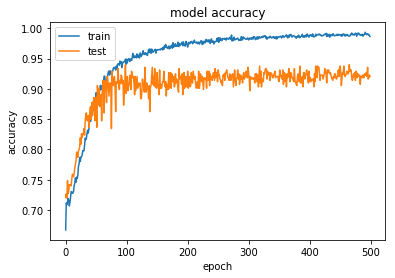

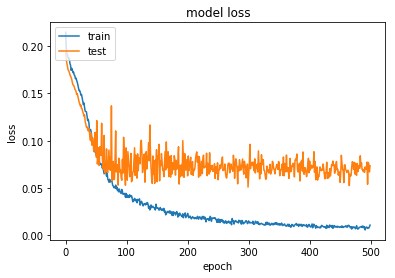

In [7]:
# Now, fit the model to the data
history = model.fit(x, y, validation_data=(x_dev, y_dev), epochs=500, batch_size=32)

# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Load pretrained conv model

In [5]:
# load json and create model
json_file = open('trained/conv_model_best.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_best.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [ ]:
x_test, y_test = nn_utils.load_dataset(im_dir="test")

In [10]:
# Evaluate model, get metrics back
stats = model.evaluate(x_dev, y_dev)
# Calculate predictions vector from model
predictions = model.predict(x_dev)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on DEV set")
print("..........................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print("..........................")
print("List of indices of wrong guesses:")
print(bad_list)

465/465 [==============================] - 2s 3ms/step

Performance on DEV set
..........................
Loss: 0.0736078283479
Accuracy: 0.920430107783
Precision: 0.991097922849
Recall: 0.907608695652
..........................
List of indices of wrong guesses:
[13, 18, 25, 28, 30, 43, 48, 72, 117, 128, 157, 159, 163, 195, 235, 245, 278, 291, 292, 308, 314, 334, 338, 345, 351, 354, 362, 370, 390, 393, 403, 410, 433, 434, 440, 452, 454]


##### Look at an image

label: [0]
prediction: [ 1.]
(236, 348, 3)


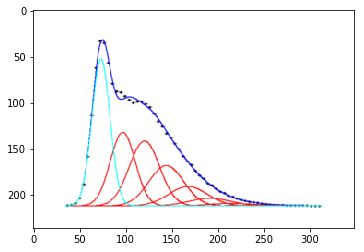

In [11]:
# Choose an index 
index = 72
# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(nn_utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [8]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_500.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_500.h5")
print("Saved model to disk")

Saved model to disk
